In [16]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


In [17]:
df = pd.read_csv('/content/Mall_Customers.csv')

In [18]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [19]:
# preprocessing
df.isnull().sum()

,0
CustomerID,0
Genre,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [20]:
df.duplicated().sum()

np.int64(0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [22]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [23]:
df.drop('CustomerID', axis=1, inplace=True)

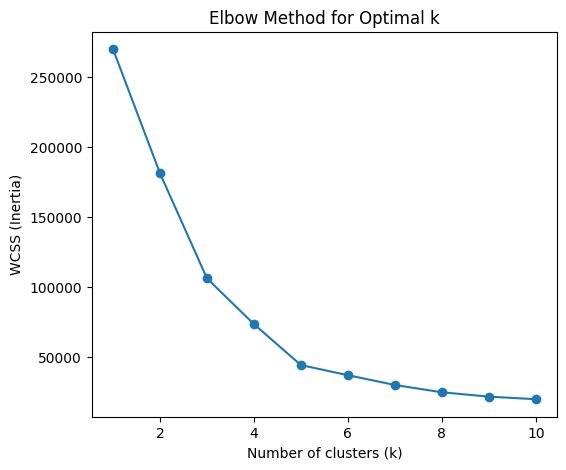

In [24]:
# step 1
inertia = []   # inertia = WCSS (Within-Cluster Sum of Squares)
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[["Annual Income (k$)", "Spending Score (1-100)"]])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 5))
plt.plot(K_range, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.show()

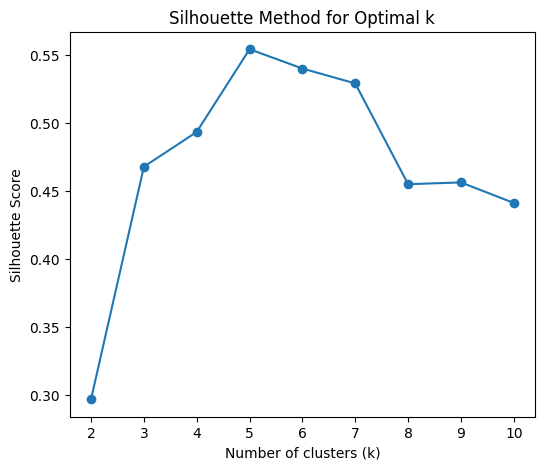

Optimal k based on Silhouette method: 5


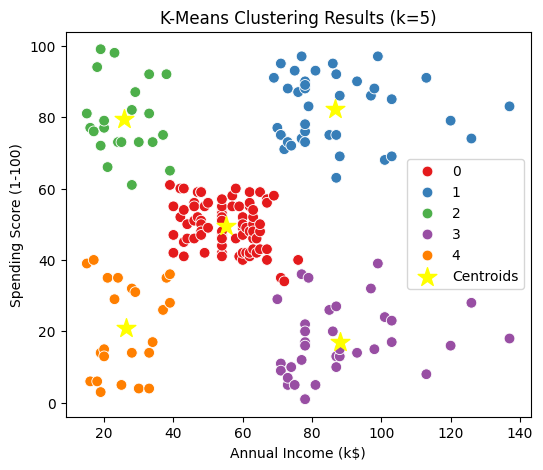

In [25]:
# Step 1 (continued) (Silhouette method)
silhouette_scores = []
for k in K_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[["Annual Income (k$)", "Spending Score (1-100)"]])
    score = silhouette_score(df[["Annual Income (k$)", "Spending Score (1-100)"]], kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 5))
plt.plot(K_range[1:], silhouette_scores, marker="o")
plt.title("Silhouette Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

optimal_k_silhouette = K_range[1:][np.argmax(silhouette_scores)]
print(f"Optimal k based on Silhouette method: {optimal_k_silhouette}")

kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=10)
df["KMeans_Cluster_Silhouette"] = kmeans_silhouette.fit_predict(df[["Annual Income (k$)", "Spending Score (1-100)"]])

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="Annual Income (k$)", y="Spending Score (1-100)", hue="KMeans_Cluster_Silhouette",
    data=df, palette="Set1", s=60
)
plt.scatter(
    kmeans_silhouette.cluster_centers_[:, 0], kmeans_silhouette.cluster_centers_[:, 1],
    s=200, c="yellow", marker="*", label="Centroids"
)
plt.title(f"K-Means Clustering Results (k={optimal_k_silhouette})")
plt.legend()
plt.show()

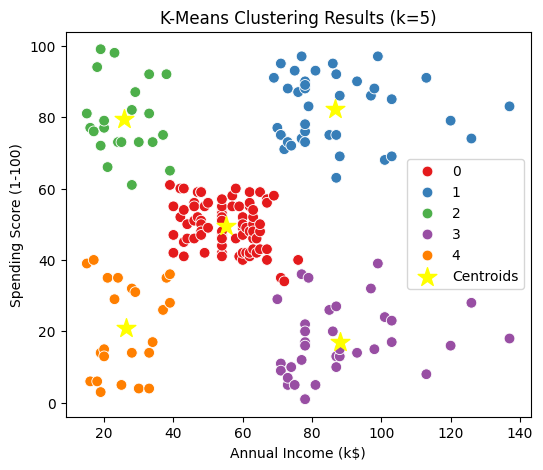

In [26]:
# Step 2: Fit K-Means with chosen k (e.g., k=5 from elbow)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(df[["Annual Income (k$)", "Spending Score (1-100)"]])

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="Annual Income (k$)", y="Spending Score (1-100)", hue="KMeans_Cluster",
    data=df, palette="Set1", s=60
)
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=200, c="yellow", marker="*", label="Centroids"
)
plt.title("K-Means Clustering Results (k=5)")
plt.legend()
plt.show()

In [27]:
# Step 3: Evaluate K-Means using Silhouette Score

sil_score = silhouette_score(df[["Annual Income (k$)", "Spending Score (1-100)"]], df["KMeans_Cluster"])
print(f"Silhouette Score for KMeans (k=5): {sil_score:.3f}")

Silhouette Score for KMeans (k=5): 0.554


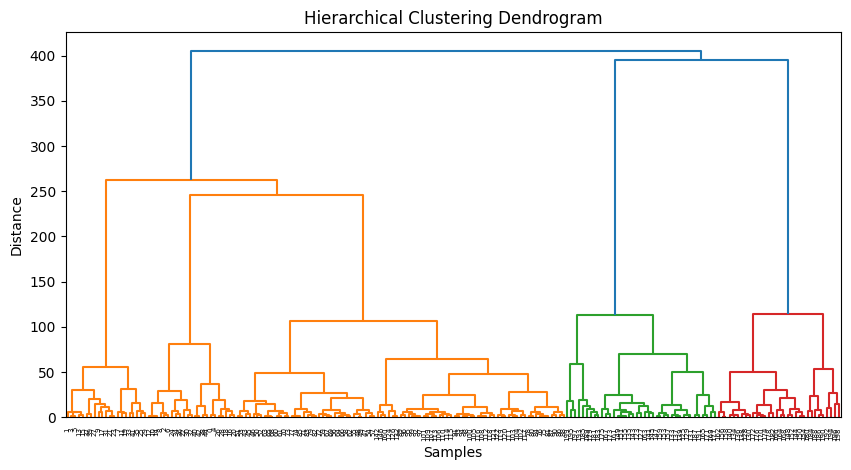

In [28]:
# Step 4: Apply Hierarchical Clustering

# Create linkage matrix using Ward’s method (minimizes variance)
Z = linkage(df[["Annual Income (k$)", "Spending Score (1-100)"]], method="ward")

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

Optimal k for Hierarchical Clustering (Silhouette method): 5


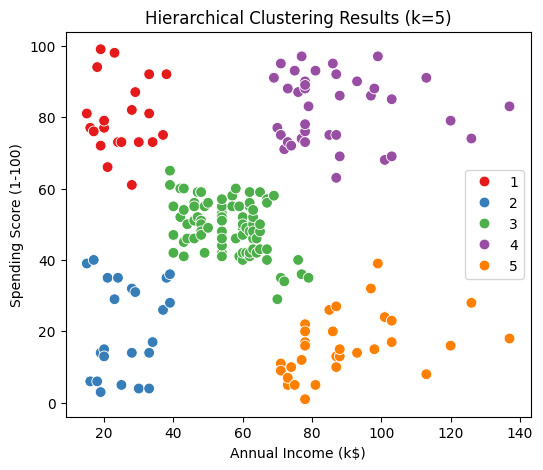

In [29]:
# Step 4 (continued) (Silhouette method)

max_silhouette_score_hierarchical = -1
optimal_k_hierarchical = -1

for k in range(2, 11):
    clusters = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(df[["Annual Income (k$)", "Spending Score (1-100)"]], clusters)
    if score > max_silhouette_score_hierarchical:
        max_silhouette_score_hierarchical = score
        optimal_k_hierarchical = k

print(f"Optimal k for Hierarchical Clustering (Silhouette method): {optimal_k_hierarchical}")

df["Hierarchical_Cluster_Silhouette"] = fcluster(Z, optimal_k_hierarchical, criterion='maxclust')

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="Annual Income (k$)", y="Spending Score (1-100)", hue="Hierarchical_Cluster_Silhouette",
    data=df, palette="Set1", s=60
)
plt.title(f"Hierarchical Clustering Results (k={optimal_k_hierarchical})")
plt.legend()
plt.show()